# Create a smooth fiducial for SOLikeT/lensing

In this notebook, we generate a fiducial smooth (i.e., binned spectrum-based theoretical prediction, no map-based random realization) dataset. We start from lensing spectra (lensing).

In [1]:
%matplotlib inline
import os
import tempfile

import camb
import cobaya
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

print("     Numpy :", np.__version__)
print("Matplotlib :", mpl.__version__)
print("      CAMB :", camb.__version__)
print("    Cobaya :", cobaya.__version__)

     Numpy : 1.24.3
Matplotlib : 3.8.0
      CAMB : 1.5.0
    Cobaya : 3.3.2


In [2]:
# Fiducial cosmo params. When used in a MCMC, the smooth data must agree with this input values

# set neutrino masses
m1=0
m2=np.sqrt(7.5e-5)
m3=np.sqrt(2.5e-3)

sumnu=m1+m2+m3

f1=m1/sumnu
f2=m2/sumnu
f3=m3/sumnu

print('sumnu =', sumnu)
print('')
print('f1 =', f1, '\nf2 =', f2, '\nf3 =', f3)

cosmo_params = {
    "cosmomc_theta": 0.0104090,
    "logA": {"value": 3.045, "drop": True},
    "As": {"value": "lambda logA: 1e-10*np.exp(logA)"},
    "ombh2": 0.02236,
    "omch2": 0.1202,
    "ns": 0.9649,
    "Alens": 1.0,
    "tau": 0.0544,
    "mnu": sumnu,
    "nnu": 3.044,
}

sumnu = 0.05866025403784439

f1 = 0.0 
f2 = 0.14763410387308012 
f3 = 0.8523658961269198


Let's use SOLikeT/lensing to generate the fiducial spectra

In [3]:
packages_path = "/Users/bradamante/Google Drive/My Drive/Work/Projects/Open/cobaya_packages/"

In [4]:
#pre = "data_sacc_"
info = {
    "likelihood": {
        "soliket.LensingLikelihood": {
            "theory_lmax": 5000,
            "stop_at_error": False}
    },
    "theory": {"camb": {"extra_args": {"lens_potential_accuracy": 1,
                                       "WantTransfer": True,
                                       "Transfer.high_precision": True,
                                       "Transfer.kmax": 1.2,
                                       "num_nu_massless": 1.044, #we use the minimal normal ordering case: massless lightest state, m2 and m3 computed according to oscilation measurements
                                       "num_nu_massive": 2, 
                                       "nu_mass_eigenstates": 2, 
                                       "nu_mass_fractions": [f2,f3],
                                       "nu_mass_numbers": [1,1],
                                       "share_delta_neff": True},
                        "stop_at_error": True}},
    "params": cosmo_params,
    "packages_path": packages_path,
    "debug": True,
}

In [5]:
from cobaya.model import get_model

model = get_model(info)

 2023-10-04 17:01:54,765 [input] 'soliket.LensingLikelihood' could not be found as internal, trying external.
 2023-10-04 17:01:56,796 [tensorflow] Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
 2023-10-04 17:01:56,859 [h5py._conv] Creating converter from 7 to 5
 2023-10-04 17:01:56,860 [h5py._conv] Creating converter from 5 to 7
 2023-10-04 17:01:56,860 [h5py._conv] Creating converter from 7 to 5
 2023-10-04 17:01:56,860 [h5py._conv] Creating converter from 5 to 7
 2023-10-04 17:01:57,628 [model] Input info updated with defaults (dumped to YAML):
theory:
  camb:
    version: null
    path: null
    speed: 0.3
    stop_at_error: true
    extra_args:
      lens_potential_accuracy: 1
      WantTransfer: true
      Transfer.high_precision: true
      Transfer.kmax: 1.2
      num_nu_massless: 1.044
      num_nu_massive: 2
      nu_mass_eigenstates: 2
      nu_mass_fractions:
      - 0.14763410387308012
      -

In [6]:
#model.components
my_lensing = model.likelihood["soliket.LensingLikelihood"]
#chi2 = -2 * (model.loglikes(fg_params)[0] - my_mflike.logp_const)
model.loglikes()

(array([328.16408687]), [2.101003120287951e-09])

Let's have a look at the comparison between simulated noisy data and the smooth theory from the fiducial parms above. Note that the function ``_get_data`` from ``my_lensing`` takes the input ell-by-ell Cls from camb and bin and correct them to be compared against data.

In [7]:
# Just inspecting the diagonal part of the covariance
np.diag(my_lensing.data.cov)

array([4.27797759e-15, 2.93923775e-15, 1.34987995e-15, 8.81701045e-16,
       4.90245671e-16, 3.37935336e-16, 3.25129946e-16, 1.41719381e-16,
       5.94465897e-17, 3.01472219e-17, 2.51327754e-17, 1.30355424e-17,
       7.81582525e-18, 5.56371674e-18, 3.27624004e-18, 1.28073888e-18,
       9.22151475e-19, 1.16390907e-18, 5.84612104e-19])

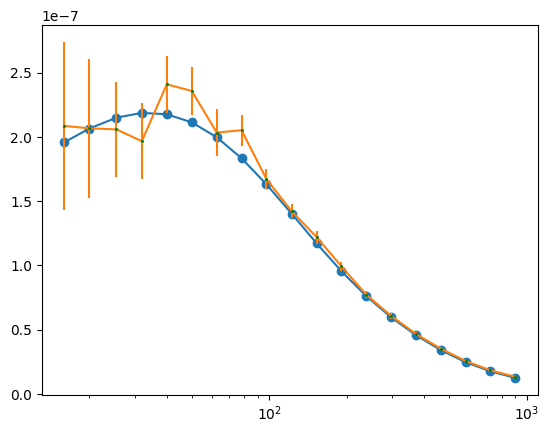

In [8]:
# Plotting data against smooth theory
plt.plot(my_lensing.bin_centers,my_lensing._get_theory(**cosmo_params),ls=None,marker='o')
plt.errorbar(my_lensing._get_data()[0],my_lensing._get_data()[1],yerr=np.sqrt(np.diag(my_lensing.data.cov)),
            marker='s', mfc='red',
                 mec='green', ms=1, mew=1)
plt.xscale('log')

We will now replace the noisy data above (in orange) with the binned smooth theory (in blue). We will make use of the astropy functions to read and write fits file. Let's access the lensing data file.

In [9]:
from astropy.io import fits

fname = packages_path+"data/LensingLikelihood/clkk_reconstruction_sim.fits"
hdul = fits.open(fname)

hdul.info()

Filename: /Users/bradamante/Google Drive/My Drive/Work/Projects/Open/cobaya_packages/data/LensingLikelihood/clkk_reconstruction_sim.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  window:TopHat    1 BinTableHDU     17   0R x 3C   [D, D, D]   
  2  window:LogTopHat    1 BinTableHDU     17   0R x 3C   [D, D, D]   
  3  window:Bandpower    1 BinTableHDU     17   3000R x 2C   [K, 19D]   
  4  tracer:Misc    1 BinTableHDU     15   0R x 2C   [D, D]   
  5  tracer:Misc    1 BinTableHDU     15   0R x 2C   [D, D]   
  6  tracer:Map:ck:beam    1 BinTableHDU     19   3000R x 2C   [K, D]   
  7  tracer:Map:ck:beam    1 BinTableHDU     19   3000R x 2C   [K, D]   
  8  data:cl_00    1 BinTableHDU     24   19R x 6C   [2A, 2A, D, K, D, K]   
  9  covariance    1 ImageHDU        11   (19, 19)   float64   


Let's have a look at the data field

In [10]:
hdul[8].data

FITS_rec([('ck', 'ck', 2.08628631e-07, 5425800144,  16. ,  0),
          ('ck', 'ck', 2.06759899e-07, 5425800144,  20. ,  1),
          ('ck', 'ck', 2.05908336e-07, 5425800144,  25.5,  2),
          ('ck', 'ck', 1.96722358e-07, 5425800144,  32. ,  3),
          ('ck', 'ck', 2.40971873e-07, 5425800144,  40. ,  4),
          ('ck', 'ck', 2.35862718e-07, 5425800144,  50. ,  5),
          ('ck', 'ck', 2.03424162e-07, 5425800144,  62.5,  6),
          ('ck', 'ck', 2.05268642e-07, 5425800144,  78. ,  7),
          ('ck', 'ck', 1.67222709e-07, 5425800144,  97.5,  8),
          ('ck', 'ck', 1.42266397e-07, 5425800144, 122. ,  9),
          ('ck', 'ck', 1.22087124e-07, 5425800144, 152.5, 10),
          ('ck', 'ck', 9.93342229e-08, 5425800144, 190.5, 11),
          ('ck', 'ck', 7.72285021e-08, 5425800144, 238. , 12),
          ('ck', 'ck', 6.06240806e-08, 5425800144, 297.5, 13),
          ('ck', 'ck', 4.65456694e-08, 5425800144, 371.5, 14),
          ('ck', 'ck', 3.51545230e-08, 5425800144, 463.

In [11]:
hdul[8].data["value"]

array([2.08628631e-07, 2.06759899e-07, 2.05908336e-07, 1.96722358e-07,
       2.40971873e-07, 2.35862718e-07, 2.03424162e-07, 2.05268642e-07,
       1.67222709e-07, 1.42266397e-07, 1.22087124e-07, 9.93342229e-08,
       7.72285021e-08, 6.06240806e-08, 4.65456694e-08, 3.51545230e-08,
       2.56248418e-08, 1.83831188e-08, 1.33608071e-08])

Now, let's replace the ``value`` field with the binned smooth theory

In [12]:
hdul[8].data["value"][:] = my_lensing._get_theory(**cosmo_params)

Let's check that the field has been overwritten with the new data

In [13]:
hdul[8].data["value"]

array([1.95837749e-07, 2.06553204e-07, 2.15011849e-07, 2.18769399e-07,
       2.17685390e-07, 2.11402261e-07, 1.99797957e-07, 1.83443646e-07,
       1.63116075e-07, 1.40375459e-07, 1.17291468e-07, 9.54927850e-08,
       7.61166694e-08, 5.95137434e-08, 4.56071892e-08, 3.40343921e-08,
       2.47195798e-08, 1.76630132e-08, 1.24909588e-08])

Ok! Let's now save the new fits object in a new fits file.

In [14]:
ndir = packages_path+"data/LensingLikelihood/soliket_lensing/smooth_data/clkk_reconstruction_sim_smooth.fits"
hdul.writeto(ndir, overwrite=True)

# Test new data

Let's read the newly created data and check that we get chi2=0 if compared against same fiducial

In [15]:
info = {
    "likelihood": {
        "soliket.LensingLikelihood": {
            #"data_folder": namedir,
            "data_filename": "soliket_lensing/smooth_data/clkk_reconstruction_sim_smooth.fits",
            "theory_lmax": 5000,
            "stop_at_error": False,
        }
    },
    "theory": {"camb": {"extra_args": {"lens_potential_accuracy": 1,
                                       "WantTransfer": True,
                                       "Transfer.high_precision": True,
                                       "Transfer.kmax": 1.2,
                                       "num_nu_massless": 1.044, #we use the minimal normal ordering case: massless lightest state, m2 and m3 computed according to oscilation measurements
                                       "num_nu_massive": 2, 
                                       "nu_mass_eigenstates": 2, 
                                       "nu_mass_fractions": [f2,f3],
                                       "nu_mass_numbers": [1,1],
                                       "share_delta_neff": True},
                        "stop_at_error": True}},
    "params": cosmo_params,
    "packages_path": packages_path,
    "debug": True,
}

In [16]:
from cobaya.model import get_model

model_test = get_model(info)

 2023-10-04 17:02:35,600 [input] 'soliket.LensingLikelihood' could not be found as internal, trying external.
 2023-10-04 17:02:35,607 [model] Input info updated with defaults (dumped to YAML):
theory:
  camb:
    version: null
    path: null
    speed: 0.3
    stop_at_error: true
    extra_args:
      lens_potential_accuracy: 1
      WantTransfer: true
      Transfer.high_precision: true
      Transfer.kmax: 1.2
      num_nu_massless: 1.044
      num_nu_massive: 2
      nu_mass_eigenstates: 2
      nu_mass_fractions:
      - 0.14763410387308012
      - 0.8523658961269198
      nu_mass_numbers:
      - 1
      - 1
      share_delta_neff: true
    ignore_obsolete: false
    use_renames: false
    external_primordial_pk: false
    renames:
      omegabh2: ombh2
      omegach2: omch2
      omegal: omega_de
      omegak: omk
      yhe: YHe
      yheused: YHe
      YpBBN: Y_p
likelihood:
  soliket.LensingLikelihood:
    data_folder: LensingLikelihood/
    data_filename: soliket_lensing/smoo

In [17]:
my_lensing_test = model_test.likelihood["soliket.LensingLikelihood"]
model_test.loglikes()

(array([343.33859468]), [2.101003120287951e-09])

Let's have a qualitative look at the comparison between smooth data and binned theory (obtained from the very same fiducial params). They should coincide!

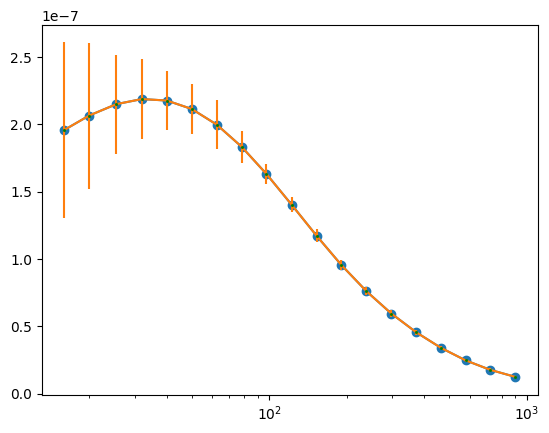

In [18]:
plt.plot(my_lensing_test.bin_centers,my_lensing_test._get_theory(**cosmo_params),ls=None,marker='o')
plt.errorbar(my_lensing_test._get_data()[0],my_lensing_test._get_data()[1],yerr=np.sqrt(np.diag(my_lensing_test.data.cov)),
            marker='s', mfc='red',
                 mec='green', ms=1, mew=1)
plt.xscale('log')

Ok! Let's now quantitatively check that data and theory are the same. We can do that by taking the difference between data and theory, and by computing the chi2 part of the loglike. Both should be zero!

In [19]:
my_lensing_test._get_theory(**cosmo_params)-my_lensing_test._get_data()[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [20]:
delta = my_lensing_test._get_theory(**cosmo_params)-my_lensing_test._get_data()[1]
-0.5 * np.dot(delta, np.linalg.inv(my_lensing_test._get_cov()).dot(delta))

-0.0

Awesome!!!